In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r drive/MyDrive/IFT780/TP2/prog/* .

# TP2: Batch normalisation [1]

Il n'y a rien à coder à proprement parler dans ce notebook.  Par contre, assurez-vous de bien comprendre comment intégrer une opération de batch-norm à un modèle car vous en aurez besoin dans le notebook **cnn**.

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

In [2]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
from utils.gradients import evaluate_numerical_gradient
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cicles dev
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean

    # Ajout du biais
    X_ = np.hstack([X_, np.ones((X.shape[0], 1))])
    
    return X_

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)


<font size="5">BatchNorm</font>

<font size="3">Forward</font>

In [5]:
from model.Model import Model
from layers.BatchNorm import BatchNorm
from utils.model_loss import cross_entropy_loss

def create_data():
    np.random.seed(1)
    N, D1, D2, D3 = 200, 50, 60, 3
    X = np.random.randn(N, D1)
    W1 = np.random.randn(D1, D2)
    W2 = np.random.randn(D2, D3)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    return a

data = create_data()
print('means', data.mean(axis=0))
print('stds', data.std(axis=0))

def create_toy_model(weight_scale):
    np.random.seed(0)
    model = Model()
    model.add(BatchNorm(3, weight_scale=weight_scale))
    model.add_loss(cross_entropy_loss)
    return model


model = create_toy_model(None)
data_norm = model.forward(data)
print('means', data_norm.mean(axis=0))
print('stds', data_norm.std(axis=0))

means [-15.65636558 -51.62665966  11.56595992]
stds [34.8506054  33.03919962 39.74692281]
means [9.54791801e-17 1.35030875e-16 5.30131494e-17]
stds [1. 1. 1.]


<font size="3">Rétro-propagation</font>

In [6]:
model = create_toy_model(1e-4)

def create_data():
    np.random.seed(30)
    X = 5 * np.random.randn(5, 3) + 12
    y = np.array([1,0,2,1,0])
    return (X, y)

correct_out = [[ 1.85344593e-06, -5.74238814e-07,  1.17228483e-06],
               [ 1.11060921e-06,  2.05814890e-07,  1.03496010e-06],
               [-4.81622969e-07,  1.04901527e-06, -4.18244822e-06],
               [ 2.64791282e-06, -5.49104141e-07,  1.05625858e-06],
               [-5.13034500e-06, -1.31487208e-07,  9.18944701e-07]]

X, y = create_data()

print(X)
scores = model.forward(X)
loss, dScores, _ = model.calculate_loss(scores, y, 0.1)
dX = model.backward(dScores)
print(dX)

# Pour chaque paramètre, l'erreur relative devrait être inférieure à environ 1e-8.
def rel_error(x, y):
    rel = np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))
    return np.max(rel)
print('difference: ', rel_error(dX, correct_out))

[[ 5.67973668 19.63952676  7.14644531]
 [14.35279808 11.49651642 13.51896592]
 [ 3.37018786 19.92547685 12.67148297]
 [ 6.46572267 19.89112775 12.53748971]
 [ 8.17976087  8.12405745 18.91923583]]
[[ 1.85344593e-06 -5.74238814e-07  1.17228483e-06]
 [ 1.11060921e-06  2.05814890e-07  1.03496010e-06]
 [-4.81622969e-07  1.04901527e-06 -4.18244822e-06]
 [ 2.64791282e-06 -5.49104141e-07  1.05625858e-06]
 [-5.13034500e-06 -1.31487208e-07  9.18944701e-07]]
difference:  2.3051923552360495e-09


<font size="3">Forward en mode test</font>

In [7]:
model = create_toy_model(None)

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)


for i in range(50):
    X = np.random.randn(N, D1)
    Z = np.maximum(0, X.dot(W1)).dot(W2)
    model.forward(Z)
    
X = np.random.randn(N, D1)
Z = np.maximum(0, X.dot(W1)).dot(W2)

A_norm = model.forward(Z, mode="test")

print('means', A_norm.mean(axis=0))
print('stds', A_norm.std(axis=0))

correct_means = [-0.0997174,  -0.02081184, -0.05757337]
corret_stds = [1.00571489, 1.06003059, 1.06759498]

print('mean difference: ', rel_error(A_norm.mean(axis=0), correct_means))
print('std difference: ', rel_error(A_norm.std(axis=0), corret_stds))

means [-0.0997174  -0.02081184 -0.05757337]
stds [1.00571489 1.06003059 1.06759498]
mean difference:  7.771780252196598e-08
std difference:  1.909140144423523e-09


<font size="5">Réseau multi-couches sans batch norm</font>

In [8]:
from model.Solver import epoch_solver, Adam
from layers.Dense import Dense

num_train = 1000

train_accuracy_histories = []
val_accuracy_histories = []
loss_histories = []

X_train_small = X_train[:num_train]
y_train_small = y_train[:num_train]

def create_model(weight_scale):
    model = Model()
    classes = 10
    hidden_size = 100
    
    dense1 = Dense(dim_output=hidden_size, weight_scale=weight_scale, activation='relu')
    dense2 = Dense(dim_input=hidden_size, dim_output=hidden_size, weight_scale=weight_scale, activation='relu')
    dense3 = Dense(dim_input=hidden_size, dim_output=hidden_size, weight_scale=weight_scale, activation='relu')
    dense4 = Dense(dim_input=hidden_size, dim_output=hidden_size, weight_scale=weight_scale, activation='relu')
    dense5 = Dense(dim_input=hidden_size, dim_output=classes, weight_scale=weight_scale)
    
    model.add(dense1, 'dense1')
    model.add(dense2, 'dense2')
    model.add(dense3, 'dense3')
    model.add(dense4, 'dense4')
    model.add(dense5, 'dense5')
    model.add_loss(cross_entropy_loss)
    optimizer = Adam(1e-3, model)
    return optimizer

optimizer = create_model(1e-2)
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train_small, 
                                                                          y_train_small,
                                                                          X_val,
                                                                          y_val,
                                                                          0.0,
                                                                          optimizer,
                                                                          epochs=10,
                                                                          batch_size=50)

loss_histories.append(loss_history)
train_accuracy_histories.append(train_accuracy_history)
val_accuracy_histories.append(val_accuracy_history)

(batch 20 / 20) loss: 2.049910
(epoch 1 / 10) loss: 2.049910, train_acc: 0.222000, val_acc: 0.214000
(batch 20 / 20) loss: 2.203933
(epoch 2 / 10) loss: 2.203933, train_acc: 0.262000, val_acc: 0.214000
(batch 20 / 20) loss: 1.845689
(epoch 3 / 10) loss: 1.845689, train_acc: 0.293000, val_acc: 0.262000
(batch 20 / 20) loss: 2.136635
(epoch 4 / 10) loss: 2.136635, train_acc: 0.323000, val_acc: 0.263000
(batch 20 / 20) loss: 1.783506
(epoch 5 / 10) loss: 1.783506, train_acc: 0.403000, val_acc: 0.294000
(batch 20 / 20) loss: 1.594672
(epoch 6 / 10) loss: 1.594672, train_acc: 0.406000, val_acc: 0.298000
(batch 20 / 20) loss: 1.297568
(epoch 7 / 10) loss: 1.297568, train_acc: 0.500000, val_acc: 0.301000
(batch 20 / 20) loss: 1.473422
(epoch 8 / 10) loss: 1.473422, train_acc: 0.482000, val_acc: 0.291000
(batch 20 / 20) loss: 1.128994
(epoch 9 / 10) loss: 1.128994, train_acc: 0.592000, val_acc: 0.321000
(batch 20 / 20) loss: 1.128769
(epoch 10 / 10) loss: 1.128769, train_acc: 0.661000, val_acc

<font size="5">Réseau multi-couches AVEC batch norm</font>

In [9]:
from layers.BatchNorm import BatchNorm
def create_normalized_model(weight_scale):
    model = Model()
    classes = 10
    hidden_size = 100
    
    dense1 = Dense(dim_output=hidden_size, weight_scale=weight_scale)
    dense2 = Dense(dim_input=hidden_size, dim_output=hidden_size, weight_scale=weight_scale)
    dense3 = Dense(dim_input=hidden_size, dim_output=hidden_size, weight_scale=weight_scale)
    dense4 = Dense(dim_input=hidden_size, dim_output=hidden_size, weight_scale=weight_scale)
    dense5 = Dense(dim_input=hidden_size, dim_output=classes, weight_scale=weight_scale)
    
    batch_norm1 = BatchNorm(hidden_size, activation='relu')
    batch_norm2 = BatchNorm(hidden_size, activation='relu')
    batch_norm3 = BatchNorm(hidden_size, activation='relu')
    batch_norm4 = BatchNorm(hidden_size, activation='relu')
    
    model.add(dense1, 'dense1')
    model.add(batch_norm1, 'batch_norm1')
    model.add(dense2, 'dense2')
    model.add(batch_norm2, 'batch_norm2')
    model.add(dense3, 'dense3')
    model.add(batch_norm3, 'batch_norm3')
    model.add(dense4, 'dense4')
    model.add(batch_norm4, 'batch_norm4')
    model.add(dense5, 'dense5')
    model.add_loss(cross_entropy_loss)
    optimizer = Adam(1e-3, model)
    return optimizer

optimizer = create_normalized_model(1e-2)
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train_small, 
                                                                          y_train_small,
                                                                          X_val,
                                                                          y_val,
                                                                          0.0,
                                                                          optimizer,
                                                                          epochs=10,
                                                                          batch_size=50)


loss_histories.append(loss_history)
train_accuracy_histories.append(train_accuracy_history)
val_accuracy_histories.append(val_accuracy_history)

(batch 20 / 20) loss: 2.086060
(epoch 1 / 10) loss: 2.086060, train_acc: 0.277000, val_acc: 0.246000
(batch 20 / 20) loss: 1.825168
(epoch 2 / 10) loss: 1.825168, train_acc: 0.429000, val_acc: 0.323000
(batch 20 / 20) loss: 1.567851
(epoch 3 / 10) loss: 1.567851, train_acc: 0.482000, val_acc: 0.327000
(batch 20 / 20) loss: 1.663185
(epoch 4 / 10) loss: 1.663185, train_acc: 0.493000, val_acc: 0.330000
(batch 20 / 20) loss: 1.247103
(epoch 5 / 10) loss: 1.247103, train_acc: 0.607000, val_acc: 0.308000
(batch 20 / 20) loss: 1.183214
(epoch 6 / 10) loss: 1.183214, train_acc: 0.670000, val_acc: 0.369000
(batch 20 / 20) loss: 1.059364
(epoch 7 / 10) loss: 1.059364, train_acc: 0.698000, val_acc: 0.312000
(batch 20 / 20) loss: 1.084550
(epoch 8 / 10) loss: 1.084550, train_acc: 0.726000, val_acc: 0.350000
(batch 20 / 20) loss: 0.854211
(epoch 9 / 10) loss: 0.854211, train_acc: 0.750000, val_acc: 0.339000
(batch 20 / 20) loss: 0.776158
(epoch 10 / 10) loss: 0.776158, train_acc: 0.794000, val_acc

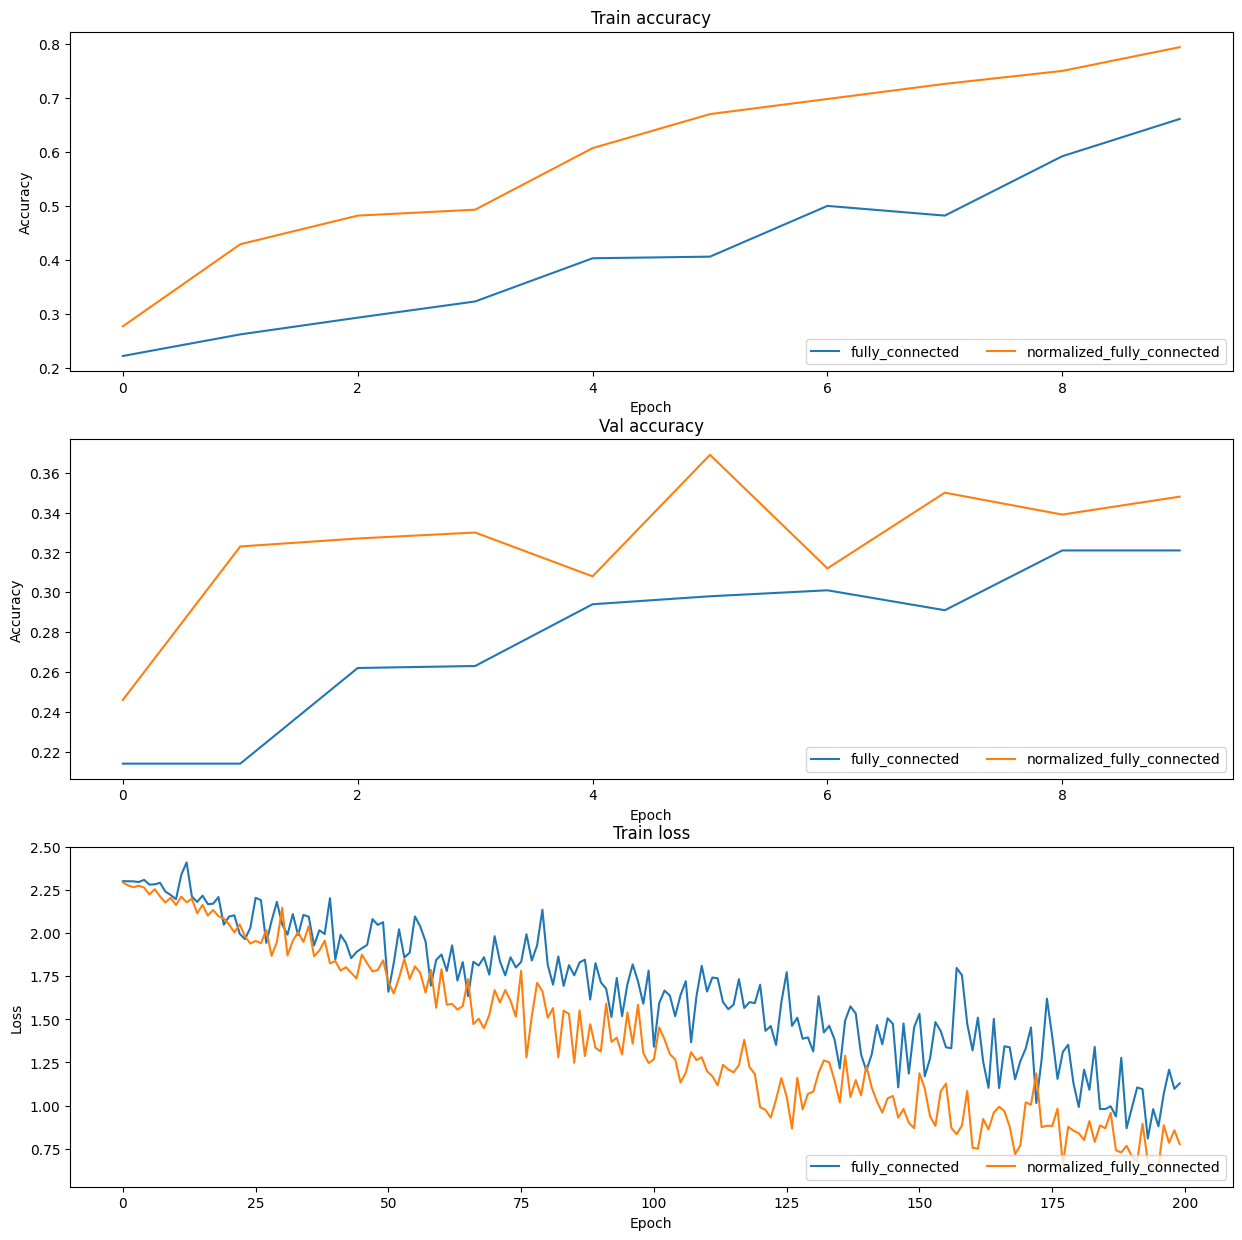

In [10]:
plt.subplot(3, 1, 1)
labels = ["fully_connected", "normalized_fully_connected"]
for i in range(2):
  plt.plot(train_accuracy_histories[i], '-', label=labels[i])
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for i in range(2):
  plt.plot(val_accuracy_histories[i], '-', label=labels[i])
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 3)
for i in range(2):
  plt.plot(loss_histories[i], '-', label=labels[i])
plt.title('Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

<font size="5">Réseau multi-couches et initialisation</font>

Ceci est une recherche d'hyper-paramètre afin de trouver le meilleur *weight_scale*.  Ce paramètre sert lors de l'initialisation des poids du réseau.

In [ ]:
weight_scales = np.logspace(-4, 0, num=20)

best_train_accs, best_norm_train_accs = [], []
best_val_accs, best_norm_val_accs = [], []
mean_train_loss, mean_norm_train_loss = [], []

for i, w in enumerate(weight_scales):
    print("Running weight scale: %i / %i : %f" % (i + 1, len(weight_scales), w))
    optimizer = create_model(w)
    norm_optimizer = create_normalized_model(w)
    loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train_small, 
                                                                          y_train_small,
                                                                          X_val,
                                                                          y_val,
                                                                          0.0,
                                                                          optimizer,
                                                                          epochs=10,
                                                                          batch_size=50,
                                                                          verbose=False)
    best_train_accs.append(max(train_accuracy_history))
    best_val_accs.append(max(val_accuracy_history))
    mean_train_loss.append(np.mean(loss_history))
    
    loss_norm_history, train_norm_accuracy_history, val_norm_accuracy_history = epoch_solver(X_train_small, 
                                                                                             y_train_small,
                                                                                             X_val,
                                                                                             y_val,
                                                                                             0.0,
                                                                                             norm_optimizer,
                                                                                             epochs=10,
                                                                                             batch_size=50,
                                                                                             verbose=False)
    
    best_norm_train_accs.append(max(train_norm_accuracy_history))
    best_norm_val_accs.append(max(val_norm_accuracy_history))
    mean_norm_train_loss.append(np.mean(loss_norm_history))

Running weight scale: 1 / 20 : 0.000100
Running weight scale: 2 / 20 : 0.000162
Running weight scale: 3 / 20 : 0.000264
Running weight scale: 4 / 20 : 0.000428
Running weight scale: 5 / 20 : 0.000695
Running weight scale: 6 / 20 : 0.001129
Running weight scale: 7 / 20 : 0.001833
Running weight scale: 8 / 20 : 0.002976
Running weight scale: 9 / 20 : 0.004833
Running weight scale: 10 / 20 : 0.007848


In [ ]:

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, best_norm_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, best_norm_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, mean_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, mean_norm_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()